In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, get_h, chirp2total, shifted_f, shifted_e, match_wfs, overlap_cplx_wfs, match_h1_h2, match_s_f_max
from calcwf import sine_model_coeffs, sine_model, quad_sine_model, maximise_quad_sine, s_f_max_sine_approx
from pycbc.types import timeseries
from pycbc.filter import match

# h1 shifted frequency with match fn

In [3]:
# Calculates match over range of intial frequency values
def s_f_h1_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Matches against h1
        match = match_wfs(h1, s, f_low, subsample_interpolation=subsample_interpolation)
        s_f_matches_1.append(abs(match))
    
        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['h1'] = s_f_matches_1
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    return data

In [4]:
# Makes plot of quad match data
def plot_s_f_h1_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01)):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='solid', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

First with subsample_interpolation=False

In [5]:
start = time.time()
sample_rate = 4096
dataslot_0 = s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10, subsample_interpolation=False)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 72.83671545982361 seconds


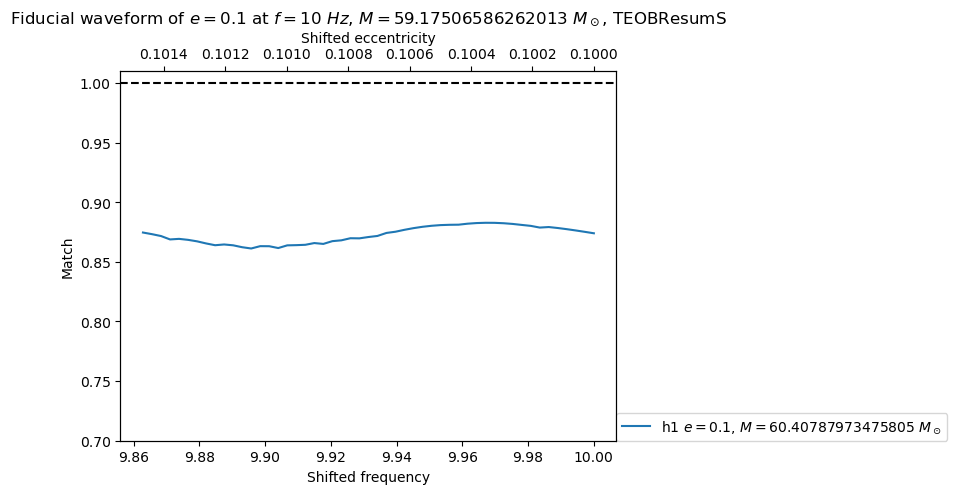

In [6]:
plot_s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_0, 10, ylims=(0.7,1.01))

Now with subsample_interpolation=True

In [7]:
start = time.time()
sample_rate = 4096
dataslot_1 = s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10, subsample_interpolation=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 72.69077038764954 seconds


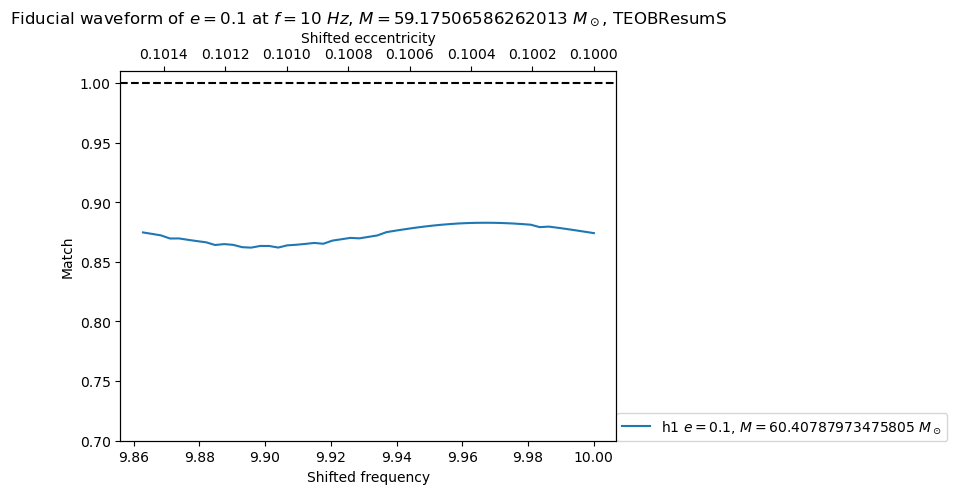

In [8]:
plot_s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_1, 10, ylims=(0.7,1.01))

# Understanding match fn index shift

1.0000000000000002 1000
1.0 2000


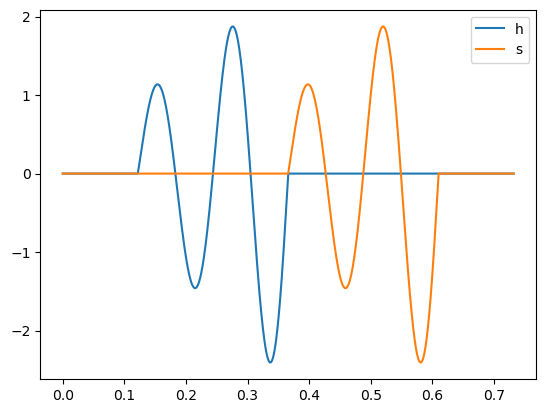

In [3]:
# Create test waveforms
times = np.linspace(1, 1000, 1000)
strain_1_insert = np.sin(2*np.pi*times/500)*np.exp(times/1000)
strain_1_h = np.array(list(np.zeros(500)) + list(strain_1_insert) + list(np.zeros(1500)))
strain_1_s = np.array(list(np.zeros(1500)) + list(strain_1_insert) + list(np.zeros(500)))
test_1_h = timeseries.TimeSeries(strain_1_h, 1/4096, epoch=0)
test_1_s = timeseries.TimeSeries(strain_1_s, 1/4096, epoch=0)

# Plot
plt.plot(test_1_h.sample_times, test_1_h, label='h')
plt.plot(test_1_s.sample_times, test_1_s, label='s')
plt.legend()

# Calculate match both ways around
m, i = match(test_1_h, test_1_s)
print(m, i)
m, i = match(test_1_s, test_1_h)
print(m, i)

Seems like outputted index is how many indices to shift first waveform by to match second. Also seems like this is cyclic, so instead of outputting a negative index shift, will output len(wf) - abs(negative shift).

# Testing match_h1_h2() function

If we input one of the trial 'waveforms' above as both h1 and h2, and the other as the trial waveform, we should hope to get the same (or very similar) match back out. We also expect this to work both ways around (i.e. for forward and backward shifts).

In [4]:
print(match_h1_h2(test_1_h, test_1_h, test_1_s, 2, return_index=True))
print(match_h1_h2(test_1_s, test_1_s, test_1_h, 2, return_index=True))

((1.0000000000000002+5.699196992113317e-17j), (0.9999999999999997-5.5479101737520995e-18j), 1000.0)
((1.0000000000000002-7.461113919362633e-17j), (0.9999999999999997-5.5479101737520995e-18j), 3096.0)


In all cases the match is almost exactly 1, with a phase of zero, as expected. Index shifts are also as expected, as the waveform lengths are resized to 4096 before the first match.

Now try with actual simulated waveforms. First off with no shifted frequency (so we expect no time shift required).

In [5]:
sample_rate = 4096
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate,
                                    approximant='TEOBResumS', subsample_interpolation=True)
s = gen_wf(10, 0.1, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS')

m1, m2, index = match_h1_h2(h1, h2, s, 10, return_index=True)
print(abs(m1), abs(m2), np.sqrt(abs(m1)**2+abs(m2)**2), index)

0.9925085400212629 0.11585616954223497 0.9992476439982924 0.14016309108176425


Match values look sensible, with quad match almost exactly 1 as expected, and there is (almost) no time shift also as expected.

Finally, test with the trial waveform shifted back by an arbitrary iirational amount of true anomaly.

In [6]:
sample_rate = 4096
s_f = np.sqrt(2)*shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_e = shifted_e(s_f, 10, 0.1)
s = gen_wf(s_f, s_e, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS')

m1, m2, index = match_h1_h2(h1, h2, s, 10, return_index=True)
print(abs(m1), abs(m2), np.sqrt(abs(m1)**2+abs(m2)**2), index)

0.9912176584636441 0.10250551518831338 0.9965038018463206 16897.517094364925


This again looks sensible.

# Shifted frequency plots with match_h1_h2()

In [2]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, _, _ = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []
    s_f_matches_quad = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Matches against h1 and h2
        m1, m2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(m1))
        s_f_matches_2.append(abs(m2))
        s_f_matches_quad.append(np.sqrt(abs(m1)**2+abs(m2)**2))
    
        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    return data

In [3]:
# Makes plot of quad match data
def plot_s_f_quad_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01), found_match=None, approx_curves=None):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='dashed', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h2'], ls='dotted', c=f'C0', label=f'h2 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['quad'], ls='solid', c=f'C0', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')

    # Add match found by maximising over shifted frequency
    if found_match is not None:
        if len(found_match) == 1:
            ax1.axhline(found_match, c='C1', ls='dashed', label='Match from maximising over shifted frequency')
        else:
            for i, key in enumerate(found_match.keys()):
                ax1.axhline(found_match[key], c=f'C{i+1}', ls='dashed', label=key)

    # Add sine approx curves if given
    if approx_curves is not None:
        for key in approx_curves.keys():
            ax1.plot(approx_curves[key][0], approx_curves[key][1], ls=approx_curves[key][2], c='k', label=key) 
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

In [13]:
start = time.time()
sample_rate = 4096
dataslot_2 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 81.91004681587219 seconds


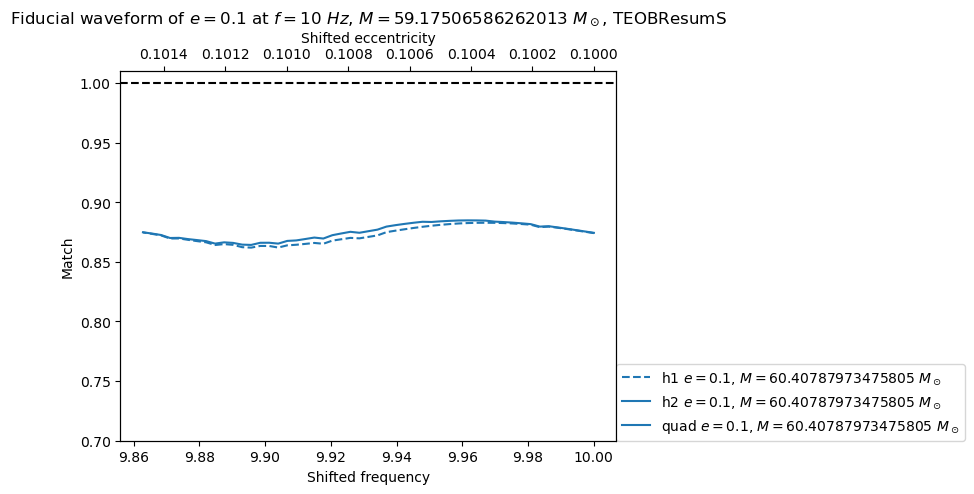

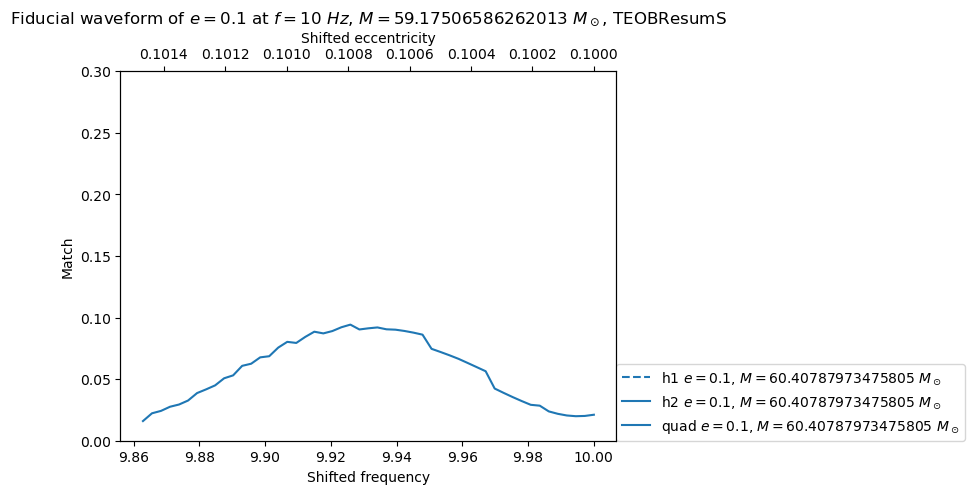

In [21]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_2, 10, ylims=(0.7,1.01)) # Plot zoom of h1, quad
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_2, 10, ylims=(0,0.3)) # Plot zoom of h2

In [15]:
start = time.time()
sample_rate = 16384
dataslot_3 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 112.11896967887878 seconds


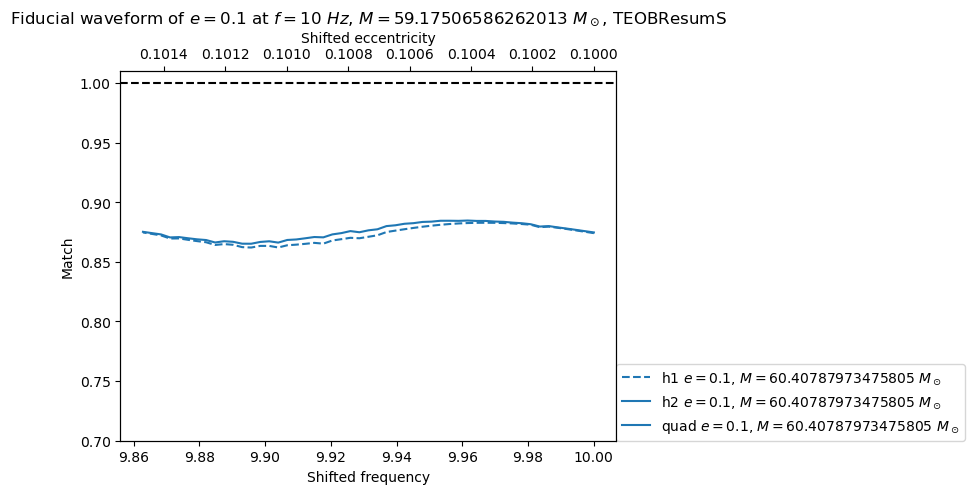

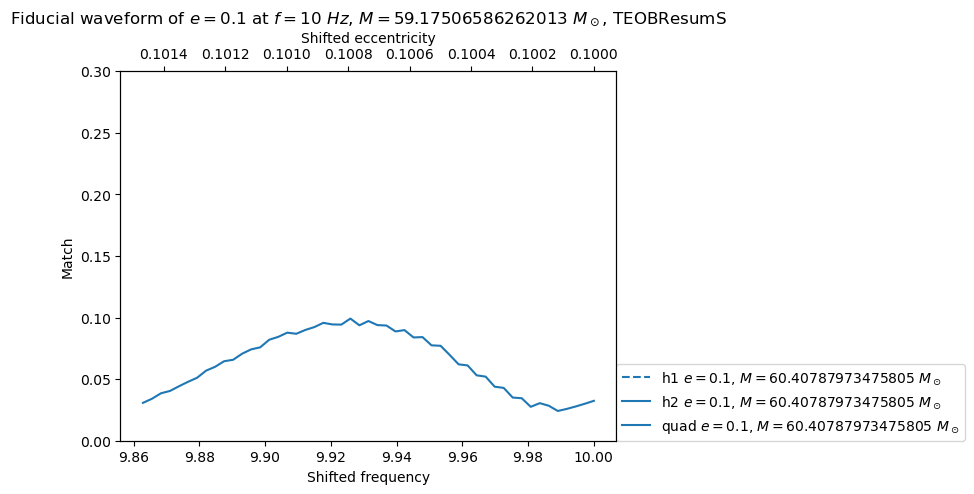

In [20]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, ylims=(0.7,1.01)) # Plot zoom of h1, quad
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, ylims=(0,0.3)) # Plot zoom of h2

# Testing s_f_max_phase_diff() function

First just test it can run without any immediate crashes/bugs

In [6]:
sample_rate = 4096
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.1, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
print(abs(match_h1), np.angle(match_h1))
print(abs(match_h2), np.angle(match_h2))
print(np.sqrt(abs(match_h1)**2+abs(match_h2)**2))

0.9924811420245628 2.1742157271198463
0.11603118661653124 2.150814482787145
0.999240738532022


Now compare match found from maximising over shifted frequency to respective shifted frequency plots

In [16]:
start = time.time()
sample_rate = 4096
dataslot_4 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.1, chirp2total(23.75, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_match_4 = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 97.33332204818726 seconds


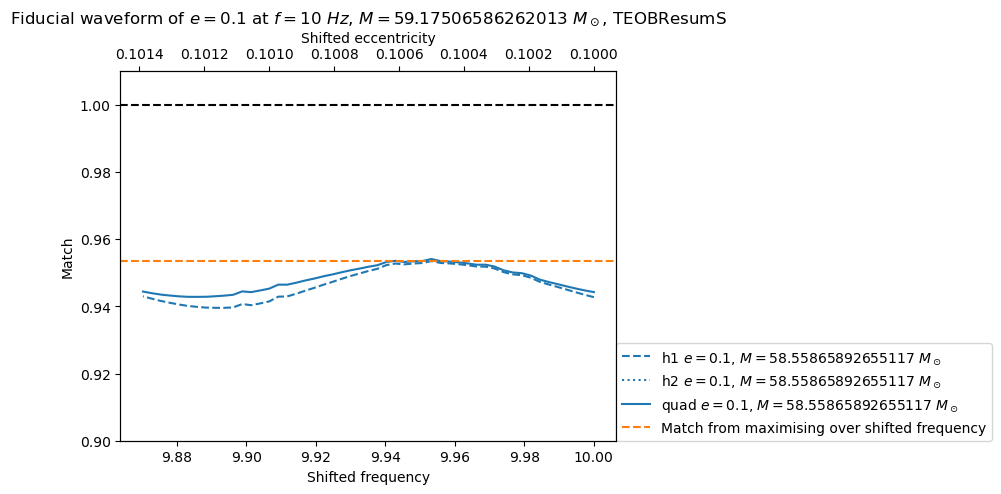

In [17]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(23.75, 2)), dataslot_4, 10, ylims=(0.9,1.01), found_match=quad_match_4)

In [15]:
start = time.time()
sample_rate = 4096
dataslot_5 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.15, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_match_5 = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 91.9203872680664 seconds


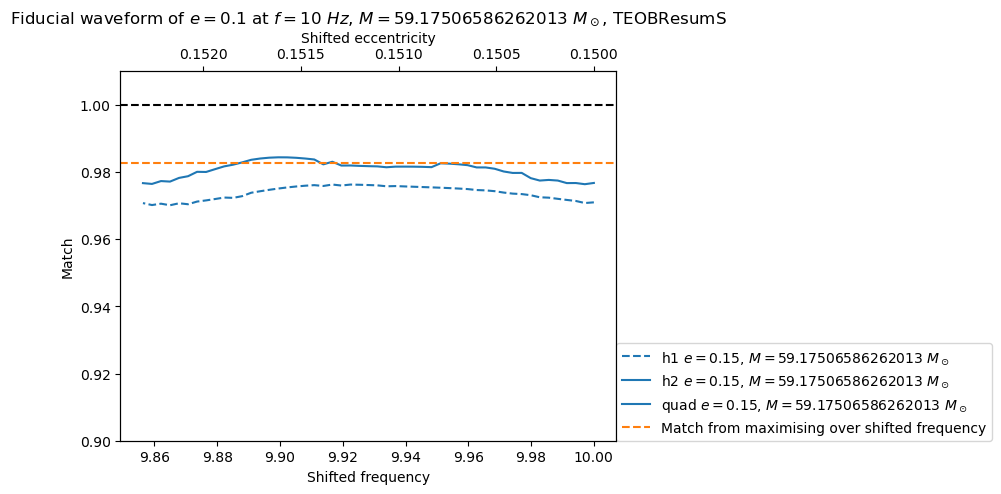

In [16]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_5, 10, ylims=(0.9,1.01), found_match=quad_match_5)

In [17]:
start = time.time()
sample_rate = 4096
dataslot_6 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.10, chirp2total(24.50, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_match_6 = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 88.56624913215637 seconds


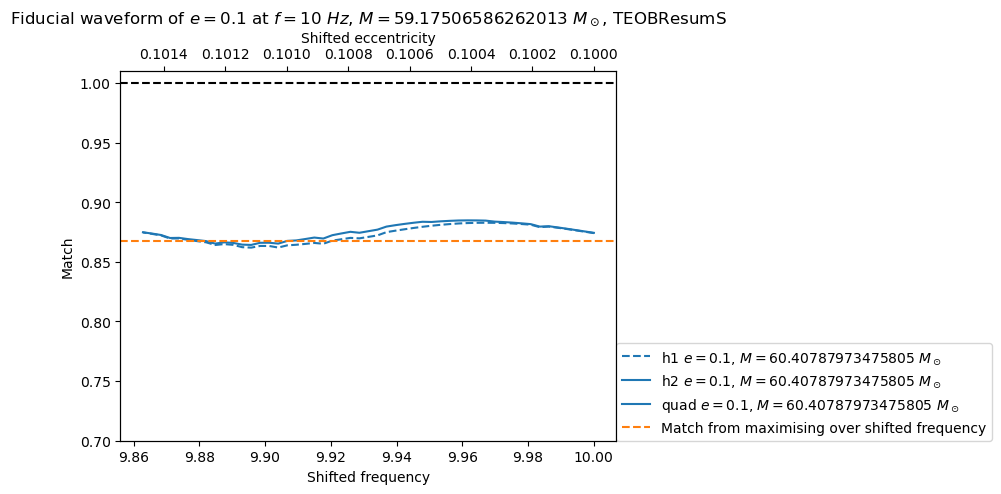

In [19]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_6, 10, ylims=(0.7,1.01), found_match=quad_match_6)

In [20]:
start = time.time()
sample_rate = 4096
dataslot_7 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.05, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_match_7 = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 85.86616396903992 seconds


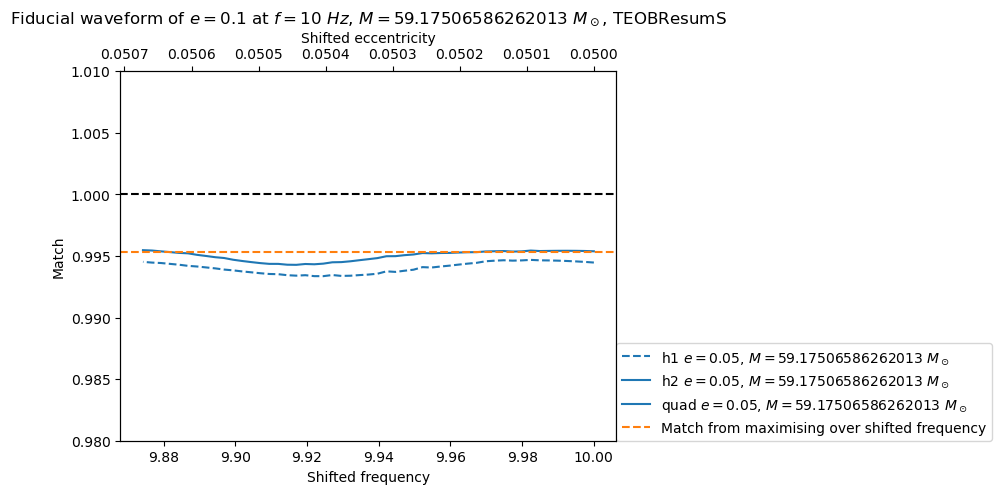

In [22]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), dataslot_7, 10, ylims=(0.98,1.01), found_match=quad_match_7)

No huge surprises here: method works well close to fiducial waveforms, gets worse at higher eccentricities due to h2 fluctuations becoming more relevant, and breaks down completely too far away from fiducial waveforms as predicted from examining phase_shifted_frequency.ipynb.

# Sine approx theory

Following method laid out here to find equations for $A, B, C$: https://math.stackexchange.com/questions/118526/fitting-a-sine-wave-of-known-frequency-through-three-points

We have a sinusoidal wave of known wavelength which we model as $m(\theta) = A \sin(\theta+B) + C$ for each of h1 and h2. There are three unknowns, so by calculating the match, $m$, at three different values of shifted frequency (represented here by $\theta$) we can fully describe the whole sinusoid. Defining $\theta = 0$ to be where the shifted frequency equals f_low (i.e. no shift), we will evaluate the match at the following points:

\begin{equation}
m(0) = A \sin B + C
\end{equation}
\begin{equation}
m(-\pi/2) = A \sin(B-\pi/2) + C = - A \cos B + C
\end{equation}
\begin{equation}
m(-\pi) = A \sin(B-\pi) + C = - A \sin B + C
\end{equation}

In order to find $C$:

\begin{equation}
m(0) + m(-\pi) = 2C
\end{equation}
\begin{equation}
C = \frac{m(0) + m(-\pi)}{2}
\end{equation}

In order to find A:

\begin{equation}
(m(0) - C)^2 + (m(-\pi/2) - C)^2 = A^2 \sin^2 B + A^2 \cos^2 B = A^2
\end{equation}
\begin{equation}
A = \sqrt{(m(0) - C)^2 + (m(-\pi/2) - C)^2}
\end{equation}

In order to find B:

\begin{equation}
\frac{m(0) - C}{-(m(-\pi/2) - C)} = \frac{A\sin B}{A\cos B} = \tan B
\end{equation}
\begin{equation}
B = \tan^{-1}\left(\frac{m(0) - C}{-(m(-\pi/2) - C)}\right) \text{, choosing the quadrant correctly.}
\end{equation}

The peak of h1 (or h2) matches then occurs at $\theta = \pi/2 - B$ with $m=A+C$. Finding the peak of the quad match is trickier:

\begin{equation}
m(\theta) = \sqrt{m_1^2 + m_2^2} = \sqrt{(A_1 \sin(\theta+B_1) + C_1)^2 + (A_2 \sin(\theta+B_2) + C_2)^2}
\end{equation}
\begin{equation}
m(\theta) = \sqrt{A_1^2\sin^2(\theta+B_1) + 2 A_1 C_1\sin(\theta+B_1) + C_1^2 + A_2^2\sin^2(\theta+B_2) + 2 A_2 C_2\sin(\theta+B_2) + C_2^2}
\end{equation}

As the match is always positive by definition, $m(\theta)$ will peak at the same value of $\theta$ as $m^2(\theta)$. We therefore choose to square both sides in order to simplify the maths.

\begin{equation}
m^2(\theta) = A_1^2\sin^2(\theta+B_1) + 2 A_1 C_1\sin(\theta+B_1) + C_1^2 + A_2^2\sin^2(\theta+B_2) + 2 A_2 C_2\sin(\theta+B_2) + C_2^2
\end{equation}
\begin{equation}
m^2(\theta) = A_1 \sin(\theta + B_1) [A_1 \sin(\theta+B_1) + 2 C_1] + C_1^2 + A_2 \sin(\theta + B_2) [A_2 \sin(\theta+B_2) + 2 C_2] + C_2^2
\end{equation}

Now take derivative of $m^2(\theta)$ with respect to $\theta$ and set equal to zero in order to find stationary points.

\begin{equation}
\frac{\mathrm{d} m^2(\theta)}{\mathrm{d}\theta} = A_1 \cos(\theta + B_1) [A_1 \sin(\theta + B_1) +  C_1] + A_2 \cos(\theta + B_2) [A_2 \sin(\theta + B_2) +  C_2] = 0
\end{equation}

Don't believe this equation can be solved analytically, so will have to use numerical methods. Will use scipy.optimize.minimize in order to find the maximum value of $m$, however there could in general be two maxima in the function so will have to test that it is indeed capable of 'escaping' the local maximum. Initial guess for location of the quad match peak will be the analytic location of the h1 match peak, i.e. $\theta = \pi/2 - B_1$.

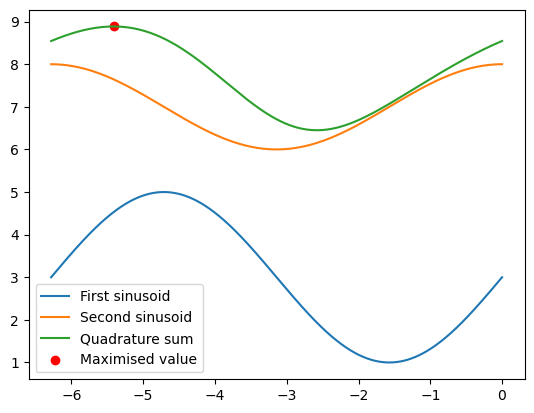

In [5]:
# Calculate some test coefficients and create array of x values
A_1, B_1, C_1 = sine_model_coeffs(3, 1, 3)
A_2, B_2, C_2 = sine_model_coeffs(8, 7, 6)
xs = np.linspace(-2*np.pi, 0, 1001)

# Calculates sinusoids and quadrature sum
sinu_1 = sine_model(xs, A_1, B_1, C_1)
sinu_2 = sine_model(xs, A_2, B_2, C_2)
sinu_quad = quad_sine_model(xs, A_1, B_1, C_1, A_2, B_2, C_2)

# Calculates maximised point
x_max = maximise_quad_sine(A_1, B_1, C_1, A_2, B_2, C_2)
sinu_quad_max = quad_sine_model(x_max, A_1, B_1, C_1, A_2, B_2, C_2)

# Plot
plt.plot(xs, sinu_1, label='First sinusoid')
plt.plot(xs, sinu_2, label='Second sinusoid')
plt.plot(xs, sinu_quad, label='Quadrature sum')
plt.scatter(x_max, sinu_quad_max, c='r', label='Maximised value')
plt.legend()

Performed well here, confirms that all moving parts seem to work. Now will test if it can escape a local maximum.

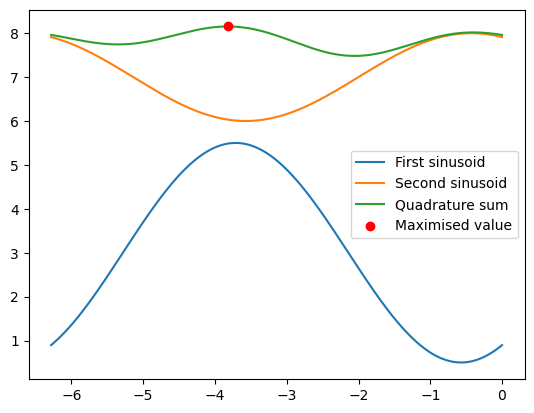

In [6]:
# Set some test coefficients and create array of x values
A_1, B_1, C_1 = 2.5, -1, 3
A_2, B_2, C_2 = 1, 2, 7
xs = np.linspace(-2*np.pi, 0, 1001)

# Calculates sinusoids and quadrature sum
sinu_1 = sine_model(xs, A_1, B_1, C_1)
sinu_2 = sine_model(xs, A_2, B_2, C_2)
sinu_quad = quad_sine_model(xs, A_1, B_1, C_1, A_2, B_2, C_2)

# Calculates maximised point
x_max = maximise_quad_sine(A_1, B_1, C_1, A_2, B_2, C_2)
sinu_quad_max = quad_sine_model(x_max, A_1, B_1, C_1, A_2, B_2, C_2)

# Plot
plt.plot(xs, sinu_1, label='First sinusoid')
plt.plot(xs, sinu_2, label='Second sinusoid')
plt.plot(xs, sinu_quad, label='Quadrature sum')
plt.scatter(x_max, sinu_quad_max, c='r', label='Maximised value', zorder=2)
plt.legend()

It can! Starts maximisation at peak of orange sinusoid (i.e. in a local maximum of the quadrature sum), but is able to escape this and find the global maximum.

# Testing s_f_max_sine_approx() function

First will overlay approximated sine curves onto a shifted frequency plot to check they are being estimated correctly.

In [20]:
start = time.time()
sample_rate = 4096
dataslot_8 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
matches, coeffs_8 = s_f_max_sine_approx(h1, h2, 10, 0.1, chirp2total(23.75, 2), 2, sample_rate, 'TEOBResumS', return_coeffs=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 95.43024110794067 seconds


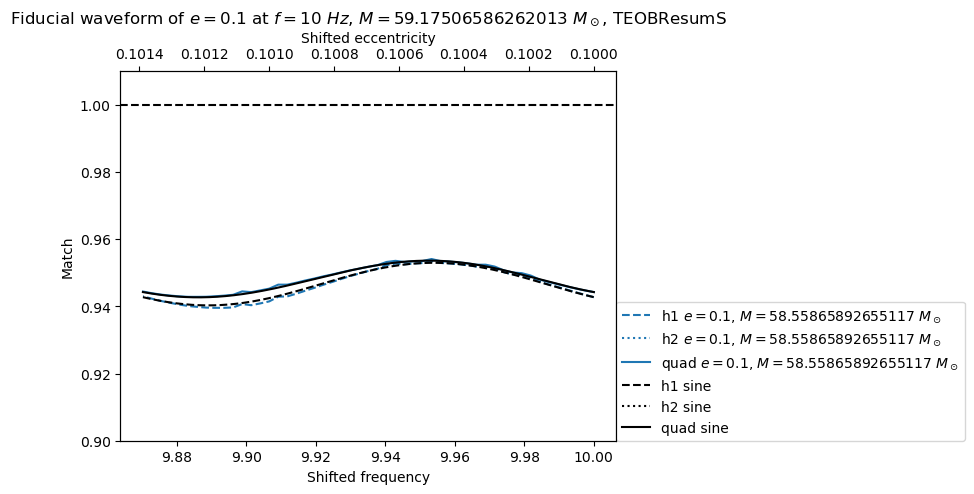

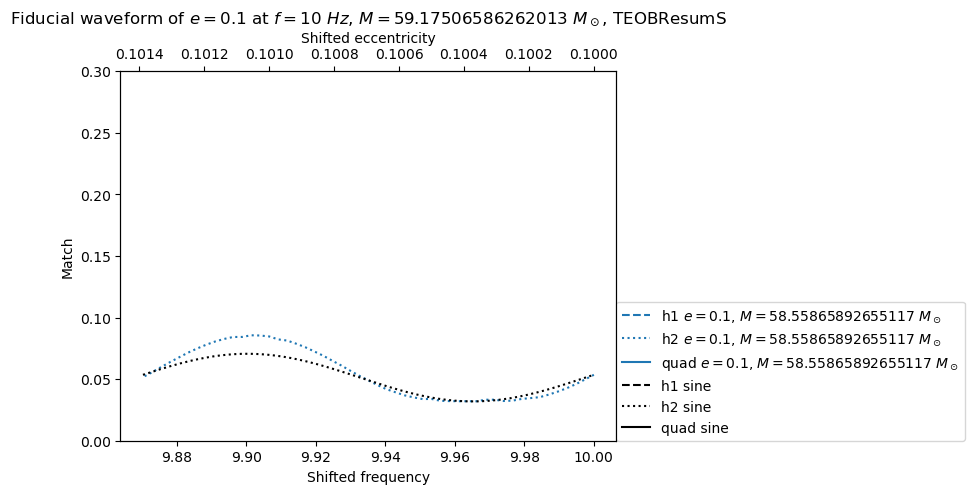

In [22]:
xs = np.linspace(-2*np.pi, 0, 1001)
sinu_1 = sine_model(xs, *coeffs_8[:3])
sinu_2 = sine_model(xs, *coeffs_8[3:])
sinu_quad = quad_sine_model(xs, *coeffs_8)
x_plot_array = np.linspace(shifted_f(10, 0.1, chirp2total(23.75, 2), 2), 10, 1001)
sinu_dict = {'h1 sine': [x_plot_array, sinu_1, 'dashed'],
             'h2 sine': [x_plot_array, sinu_2, 'dotted'],
             'quad sine': [x_plot_array, sinu_quad, 'solid']}
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(23.75, 2)), dataslot_8, 10, ylims=(0.9,1.01), approx_curves=sinu_dict)
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(23.75, 2)), dataslot_8, 10, ylims=(0,0.3), approx_curves=sinu_dict)

Works very well! Now try further away from fiducial waveform, i.e. where phase difference method breaks down.

In [23]:
start = time.time()
sample_rate = 4096
dataslot_9 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
matches, coeffs_9 = s_f_max_sine_approx(h1, h2, 10, 0.10, chirp2total(24.50, 2), 2, sample_rate, 'TEOBResumS', return_coeffs=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 91.05103206634521 seconds


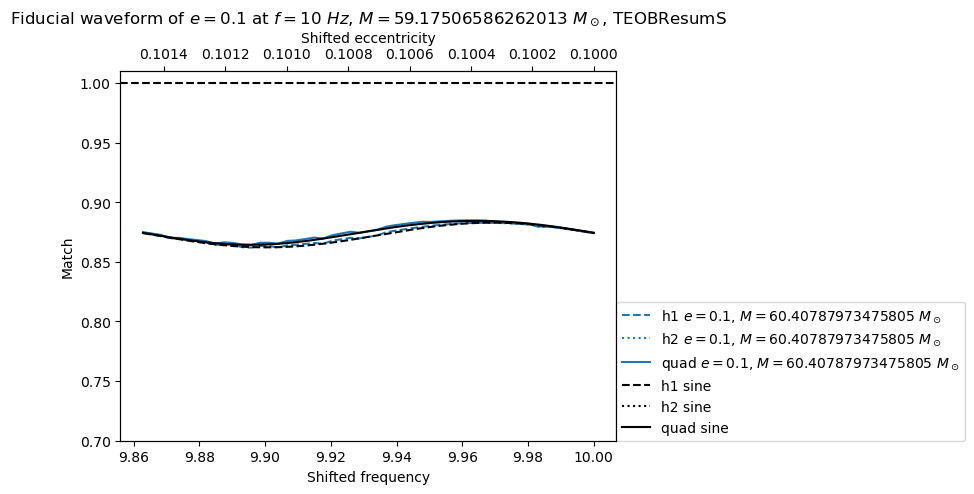

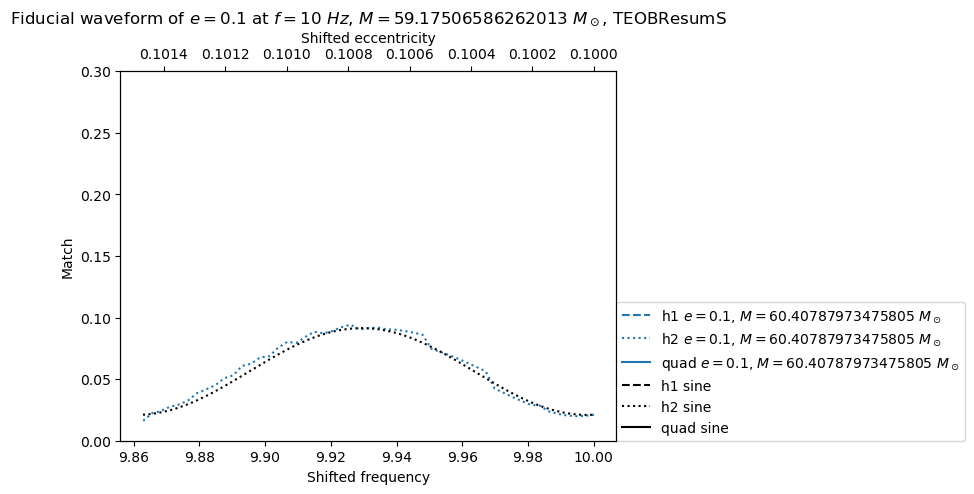

In [24]:
xs = np.linspace(-2*np.pi, 0, 1001)
sinu_1 = sine_model(xs, *coeffs_9[:3])
sinu_2 = sine_model(xs, *coeffs_9[3:])
sinu_quad = quad_sine_model(xs, *coeffs_9)
x_plot_array = np.linspace(shifted_f(10, 0.1, chirp2total(24.50, 2), 2), 10, 1001)
sinu_dict = {'h1 sine': [x_plot_array, sinu_1, 'dashed'],
             'h2 sine': [x_plot_array, sinu_2, 'dotted'],
             'quad sine': [x_plot_array, sinu_quad, 'solid']}
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_9, 10, ylims=(0.7,1.01), approx_curves=sinu_dict)
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_9, 10, ylims=(0,0.3), approx_curves=sinu_dict)

Also works very well here! Will now make plots showing estimate of match level for both phase difference and sine approx methods

In [4]:
start = time.time()
sample_rate = 4096
dataslot_10 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
quad_matches_10 = {}
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.1, chirp2total(23.75, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_matches_10['phase_diff'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.1, chirp2total(23.75, 2), 2, sample_rate, 'TEOBResumS', 'sine_approx')
quad_matches_10['sine_approx'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 97.20737051963806 seconds


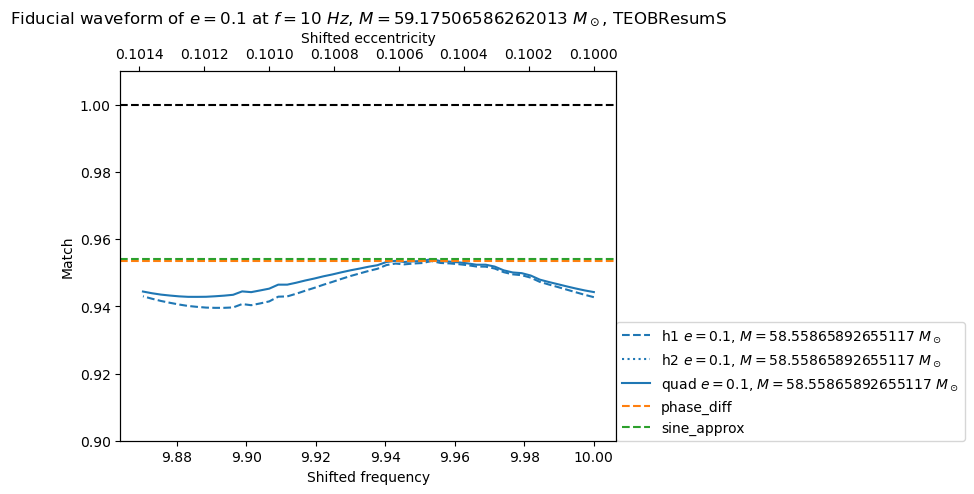

In [5]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(23.75, 2)), dataslot_10, 10, ylims=(0.9,1.01), found_match=quad_matches_10)

In [6]:
start = time.time()
sample_rate = 4096
dataslot_11 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 51, 10)
quad_matches_11 = {}
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.15, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_matches_11['phase_diff'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.15, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'sine_approx')
quad_matches_11['sine_approx'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 96.51466608047485 seconds


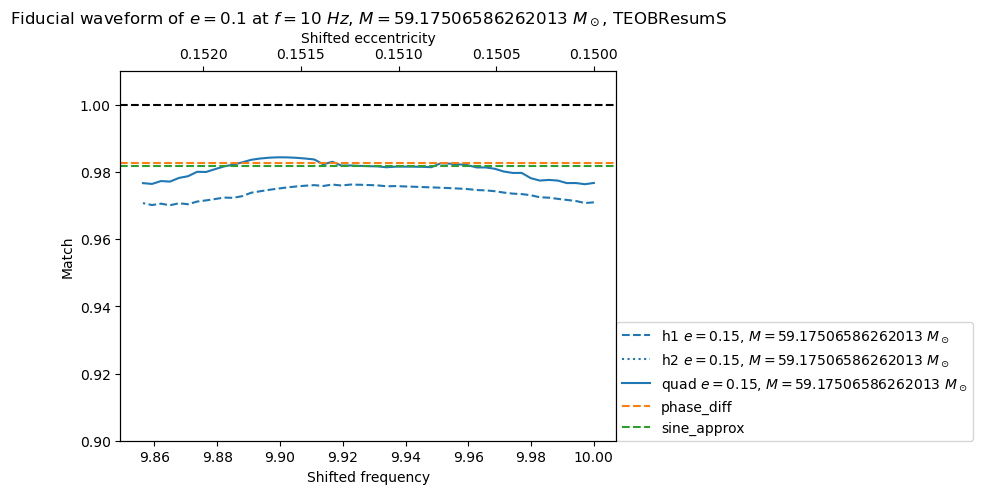

In [10]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_11, 10, ylims=(0.9,1.01), found_match=quad_matches_11)

In [8]:
start = time.time()
sample_rate = 4096
dataslot_12 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
quad_matches_12 = {}
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.10, chirp2total(24.50, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_matches_12['phase_diff'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.10, chirp2total(24.50, 2), 2, sample_rate, 'TEOBResumS', 'sine_approx')
quad_matches_12['sine_approx'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 92.21735644340515 seconds


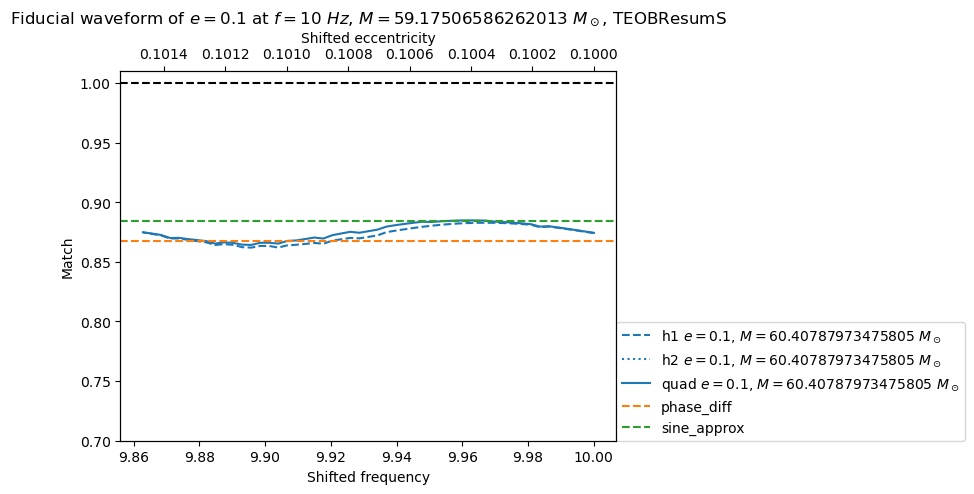

In [11]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_12, 10, ylims=(0.7,1.01), found_match=quad_matches_12)

In [12]:
start = time.time()
sample_rate = 4096
dataslot_13 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), 51, 10)
quad_matches_13 = {}
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.05, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'phase_diff')
quad_matches_13['phase_diff'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
match_h1, match_h2 = match_s_f_max(h1, h2, 10, 0.05, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', 'sine_approx')
quad_matches_13['sine_approx'] = np.sqrt(abs(match_h1)**2+abs(match_h2)**2)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 89.90264225006104 seconds


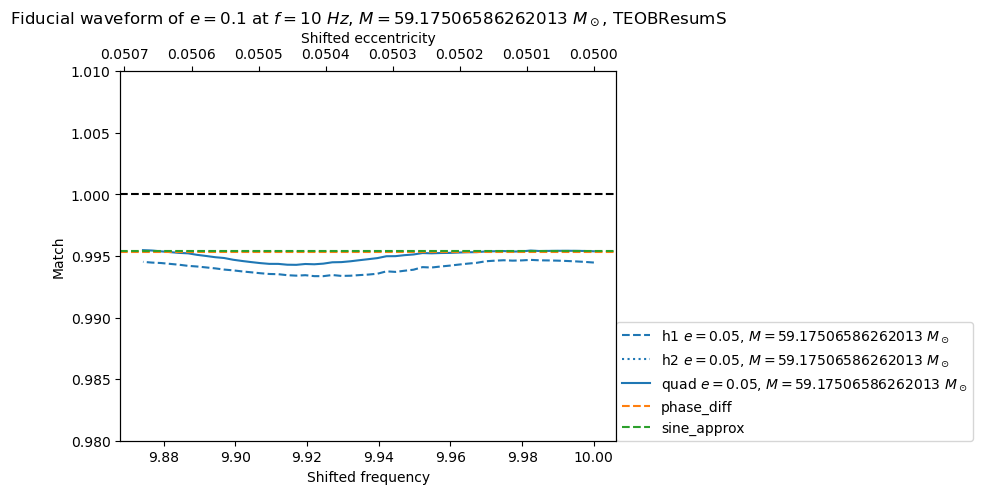

In [13]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), dataslot_13, 10, ylims=(0.98,1.01), found_match=quad_matches_13)

Similar to phase difference method in that it appears to work less well for higher eccentricities due to oscillations, however does not break down far away from fiducial waveform! Out of interest, will also now plot sine model curves on top of second shifted frequency plot here (e_10 = 0.15, chirp mass = 24 solar masses).

In [14]:
start = time.time()
sample_rate = 4096
dataslot_14 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
matches, coeffs_14 = s_f_max_sine_approx(h1, h2, 10, 0.15, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', return_coeffs=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 92.87706708908081 seconds


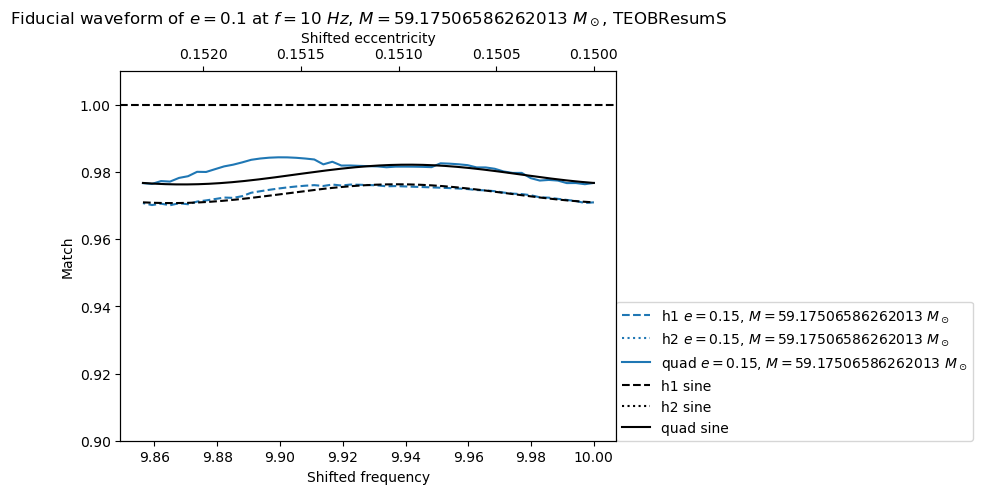

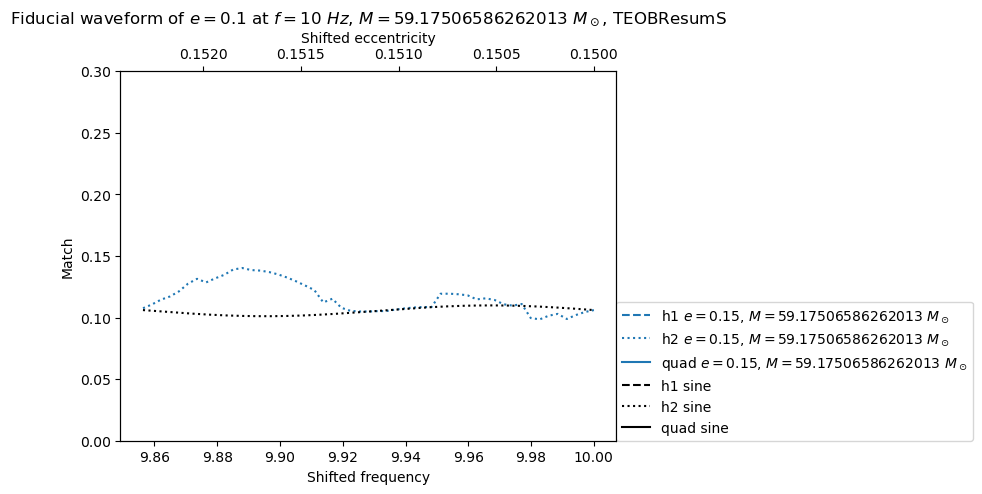

In [16]:
xs = np.linspace(-2*np.pi, 0, 1001)
sinu_1 = sine_model(xs, *coeffs_14[:3])
sinu_2 = sine_model(xs, *coeffs_14[3:])
sinu_quad = quad_sine_model(xs, *coeffs_14)
x_plot_array = np.linspace(shifted_f(10, 0.15, chirp2total(24, 2), 2), 10, 1001)
sinu_dict = {'h1 sine': [x_plot_array, sinu_1, 'dashed'],
             'h2 sine': [x_plot_array, sinu_2, 'dotted'],
             'quad sine': [x_plot_array, sinu_quad, 'solid']}
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_14, 10, ylims=(0.9,1.01), approx_curves=sinu_dict)
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_14, 10, ylims=(0,0.3), approx_curves=sinu_dict)

Approximates h1 well, but oscillations make it very hard for h2. This is obviously not ideal, but do not believe to be a massive problem as h1 is of course dominant in all cases. Again out of interest will repeat this with an increased sample rate of 16384 Hz to see extent of improvement.

In [18]:
start = time.time()
sample_rate = 16384
dataslot_15 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 51, 10)
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate, approximant='TEOBResumS', subsample_interpolation=True)
matches, coeffs_15 = s_f_max_sine_approx(h1, h2, 10, 0.15, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS', return_coeffs=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 127.7202410697937 seconds


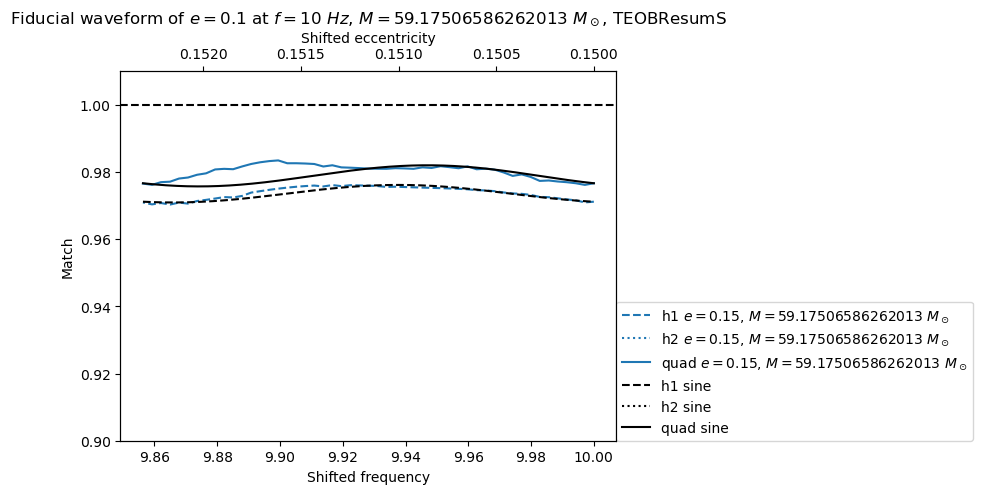

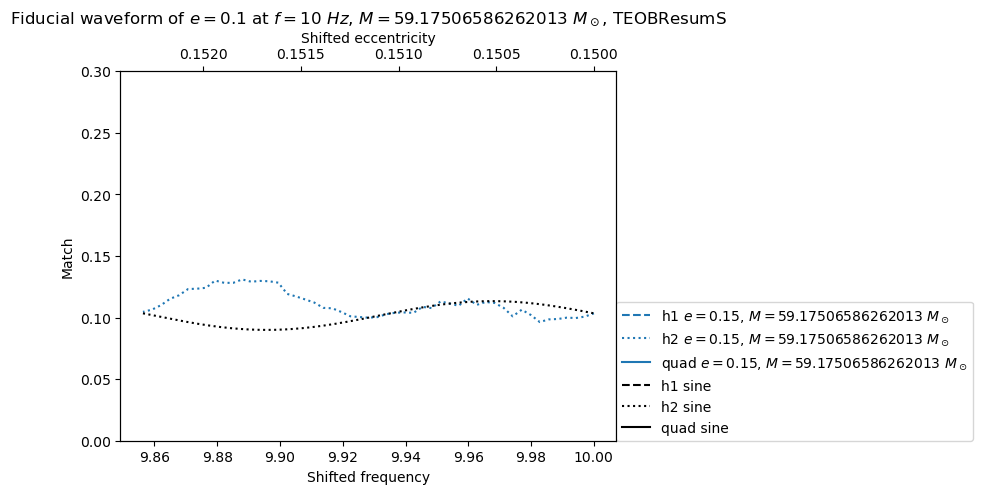

In [19]:
xs = np.linspace(-2*np.pi, 0, 1001)
sinu_1 = sine_model(xs, *coeffs_15[:3])
sinu_2 = sine_model(xs, *coeffs_15[3:])
sinu_quad = quad_sine_model(xs, *coeffs_15)
x_plot_array = np.linspace(shifted_f(10, 0.15, chirp2total(24, 2), 2), 10, 1001)
sinu_dict = {'h1 sine': [x_plot_array, sinu_1, 'dashed'],
             'h2 sine': [x_plot_array, sinu_2, 'dotted'],
             'quad sine': [x_plot_array, sinu_quad, 'solid']}
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_15, 10, ylims=(0.9,1.01), approx_curves=sinu_dict)
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_15, 10, ylims=(0,0.3), approx_curves=sinu_dict)